# Latent Space

> Scripts to visualize and explore the Latent Space

In [1]:
#| default_exp latent_space

In [2]:
#| export
#| hide
import numpy as np
from itertools import combinations
from scipy.spatial import distance
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import LabelEncoder
from typing import Optional, List, Any, Union, Dict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import umap.umap_ as umap
from sklearn.preprocessing import LabelEncoder
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import torch
import random

In [3]:
#| export
#| hide
from orbit_generation.architectures import Sampling

In [4]:
#| hide
from fastcore.test import test_eq, test_close

## Plot 2 dimensions

In [5]:
#| export
def plot_2d_latent_space(
    latent_representations: np.ndarray,
    labels: np.ndarray,
    latent_stdevs: Optional[np.ndarray] = None,
    features: Optional[Any] = None,
    feature_names: Optional[List[str]] = None,
    figsize: tuple = (12, 12),
    save_path: Optional[str] = None,
    many_classes: bool = False,
    show_legend: bool = True,
    legend_fontsize: int = 8,
    plot_std: bool = True,
    **kwargs: Any
) -> None:
    """
    Plots a 2D latent space visualization with class labels and feature distributions.

    Parameters:
    - latent_representations: np.ndarray, shape (n_samples, 2)
        The 2D coordinates of the latent representations.
    - labels: np.ndarray, shape (n_samples,)
        The class labels for each sample.
    - features: Optional[Any], shape (n_samples, n_features)
        The feature data to plot distributions. Can be a list or a NumPy array.
    - feature_names: Optional[List[str]]
        The names of the features.
    - figsize: tuple, default (12, 12)
        The size of the entire figure.
    - save_path: Optional[str]
        Path to save the figure. If None, the plot is not saved.
    - many_classes: bool, default False
        If True, uses different markers for classes.
    - show_legend: bool, default True
        If True, displays legends.
    - legend_fontsize: int, default 8
        Font size for the legends.
    - plot_std: bool, default True
        If True, plots the standard deviation shading for feature distributions.
    - kwargs: Any
        Additional keyword arguments passed to scatter plots.
    """
    # Normalize latent representations
    latent_representations = (latent_representations - np.mean(latent_representations, axis=0)) / np.std(latent_representations, axis=0)

    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    class_names = label_encoder.classes_

    # Colormap and markers for classes
    cmap_classes = plt.get_cmap('tab20', len(class_names))
    markers = ['o', 's', '^', 'v', 'D', '<', '>', 'p', '*', 'h', 'H', '8']

    # Define fixed colors for features
    predefined_feature_colors = ['orange', 'purple', 'green']
    if feature_names and len(feature_names) > len(predefined_feature_colors):
        # Cycle through the predefined colors if more features are present
        feature_colors = predefined_feature_colors * (len(feature_names) // len(predefined_feature_colors) + 1)
    else:
        feature_colors = predefined_feature_colors[:len(feature_names)] if feature_names else []

    # Create figure and GridSpec
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[5, 1], wspace=0.3, hspace=0.3)

    ax_main = fig.add_subplot(gs[0, 0])

    # Plot latent representations with optional error bars for standard deviation
    if many_classes:
        for class_idx, class_name in enumerate(class_names):
            class_mask = (encoded_labels == class_idx)
            color = cmap_classes(class_idx % cmap_classes.N)
            ax_main.scatter(
                latent_representations[class_mask, 0],
                latent_representations[class_mask, 1],
                label=class_name,
                color=color,
                s=30,
                **kwargs
            )
            if latent_stdevs is not None:
                ax_main.errorbar(
                    latent_representations[class_mask, 0],
                    latent_representations[class_mask, 1],
                    xerr=latent_stdevs[class_mask, 0],
                    yerr=latent_stdevs[class_mask, 1],
                    fmt='none',
                    ecolor=color,
                    alpha=0.5
                )
                
    else:
        unique_labels = np.unique(encoded_labels)
        for class_idx in unique_labels:
            class_name = class_names[class_idx]
            class_mask = (encoded_labels == class_idx)
            color = cmap_classes(class_idx % cmap_classes.N)
            ax_main.scatter(
                latent_representations[class_mask, 0],
                latent_representations[class_mask, 1],
                label=class_name,
                color=color,
                s=30,
                **kwargs
            )
            if latent_stdevs is not None:
                ax_main.errorbar(
                    latent_representations[class_mask, 0],
                    latent_representations[class_mask, 1],
                    xerr=latent_stdevs[class_mask, 0],
                    yerr=latent_stdevs[class_mask, 1],
                    fmt='none',
                    ecolor=color,
                    alpha=0.5
                )

    if show_legend:
        ax_main.legend(title="Classes", fontsize=legend_fontsize)

    ax_main.set_title('2D Latent Space Visualization')
    ax_main.set_xlabel('Dimension 1')
    ax_main.set_ylabel('Dimension 2')

    # Set equal aspect ratio and adjust limits
    ax_main.set_aspect('equal')

    x_min, x_max = latent_representations[:, 0].min(), latent_representations[:, 0].max()
    y_min, y_max = latent_representations[:, 1].min(), latent_representations[:, 1].max()

    max_range = max(x_max - x_min, y_max - y_min)

    ax_main.set_xlim(x_min - (max_range - (x_max - x_min)) / 2,
                     x_max + (max_range - (x_max - x_min)) / 2)

    ax_main.set_ylim(y_min - (max_range - (y_max - y_min)) / 2,
                     y_max + (max_range - (y_max - y_min)) / 2)

    # Plot feature distributions with standard deviation if features are provided and plot_std is True
    if features is not None and feature_names is not None:
        # Convert features to NumPy array if it's a list
        if isinstance(features, list):
            features = np.array(features)

        ax_hist_x = fig.add_subplot(gs[1, 0], sharex=ax_main)
        ax_hist_y = fig.add_subplot(gs[0, 1], sharey=ax_main)

        x_bins = np.linspace(x_min, x_max, 100)
        y_bins = np.linspace(y_min, y_max, 100)

        # Initialize lists to store legend handles for features
        feature_legend_elements = []

        for feature_index, feature_name in enumerate(feature_names):
            # Assign a specific color to each feature
            if feature_index < len(feature_colors):
                color = feature_colors[feature_index]
            else:
                color = 'gray'  # Default color if predefined colors are exhausted

            ### Plotting for x-axis
            # Compute mean and std for x-axis
            avg_feature_norm_x = [
                features[(latent_representations[:, 0] >= x_bins[i]) & (latent_representations[:, 0] < x_bins[i+1]), feature_index].mean()
                if np.any((latent_representations[:, 0] >= x_bins[i]) & (latent_representations[:, 0] < x_bins[i+1]))
                else np.nan
                for i in range(len(x_bins)-1)
            ]
            std_feature_norm_x = [
                features[(latent_representations[:, 0] >= x_bins[i]) & (latent_representations[:, 0] < x_bins[i+1]), feature_index].std()
                if np.any((latent_representations[:, 0] >= x_bins[i]) & (latent_representations[:, 0] < x_bins[i+1]))
                else np.nan
                for i in range(len(x_bins)-1)
            ]

            # Convert to NumPy arrays for easier handling
            avg_feature_norm_x = np.array(avg_feature_norm_x)
            std_feature_norm_x = np.array(std_feature_norm_x)

            # Handle NaNs
            if plot_std:
                valid_x = ~np.isnan(avg_feature_norm_x) & ~np.isnan(std_feature_norm_x)
            else:
                valid_x = ~np.isnan(avg_feature_norm_x)

            if np.any(valid_x):
                avg_x = avg_feature_norm_x[valid_x]
                bin_centers_x = (x_bins[:-1] + x_bins[1:]) / 2
                bin_centers_x = bin_centers_x[valid_x]

                # Normalize mean
                avg_min_x, avg_max_x = avg_x.min(), avg_x.max()
                ptp_x = avg_max_x - avg_min_x
                avg_norm_x = (avg_x - avg_min_x) / (ptp_x + 1e-8)

                if plot_std:
                    # Normalize std
                    std_x = std_feature_norm_x[valid_x]
                    std_min_x, std_max_x = std_x.min(), std_x.max()
                    ptp_std_x = std_max_x - std_min_x
                    if ptp_std_x > 0:
                        std_norm_x = (std_x - std_min_x) / (ptp_std_x + 1e-8)
                    else:
                        std_norm_x = np.zeros_like(std_x)

                # Plot mean line
                line_mean_x, = ax_hist_x.plot(
                    bin_centers_x,
                    avg_norm_x,
                    color=color,
                    label=f'{feature_name} Mean'
                )

                if plot_std:
                    # Plot std deviation shaded area
                    ax_hist_x.fill_between(
                        bin_centers_x,
                        avg_norm_x - std_norm_x,
                        avg_norm_x + std_norm_x,
                        color=mcolors.to_rgba(color, alpha=0.3),
                        label=f'{feature_name} Std'
                    )

                # Collect legend handles
                feature_legend_elements.append(Line2D([0], [0], color=color, lw=2, label=f'{feature_name} Mean'))
                if plot_std:
                    feature_legend_elements.append(Patch(facecolor=mcolors.to_rgba(color, alpha=0.3), edgecolor='none', label=f'{feature_name} Std'))

            ### Plotting for y-axis
            # Compute mean and std for y-axis
            avg_feature_norm_y = [
                features[(latent_representations[:, 1] >= y_bins[i]) & (latent_representations[:, 1] < y_bins[i+1]), feature_index].mean()
                if np.any((latent_representations[:, 1] >= y_bins[i]) & (latent_representations[:, 1] < y_bins[i+1]))
                else np.nan
                for i in range(len(y_bins)-1)
            ]
            std_feature_norm_y = [
                features[(latent_representations[:, 1] >= y_bins[i]) & (latent_representations[:, 1] < y_bins[i+1]), feature_index].std()
                if np.any((latent_representations[:, 1] >= y_bins[i]) & (latent_representations[:, 1] < y_bins[i+1]))
                else np.nan
                for i in range(len(y_bins)-1)
            ]

            # Convert to NumPy arrays for easier handling
            avg_feature_norm_y = np.array(avg_feature_norm_y)
            std_feature_norm_y = np.array(std_feature_norm_y)

            # Handle NaNs
            if plot_std:
                valid_y = ~np.isnan(avg_feature_norm_y) & ~np.isnan(std_feature_norm_y)
            else:
                valid_y = ~np.isnan(avg_feature_norm_y)

            if np.any(valid_y):
                avg_y = avg_feature_norm_y[valid_y]
                bin_centers_y = (y_bins[:-1] + y_bins[1:]) / 2
                bin_centers_y = bin_centers_y[valid_y]

                # Normalize mean
                avg_min_y, avg_max_y = avg_y.min(), avg_y.max()
                ptp_y = avg_max_y - avg_min_y
                avg_norm_y = (avg_y - avg_min_y) / (ptp_y + 1e-8)

                if plot_std:
                    # Normalize std
                    std_y = std_feature_norm_y[valid_y]
                    std_min_y, std_max_y = std_y.min(), std_y.max()
                    ptp_std_y = std_max_y - std_min_y
                    if ptp_std_y > 0:
                        std_norm_y = (std_y - std_min_y) / (ptp_std_y + 1e-8)
                    else:
                        std_norm_y = np.zeros_like(std_y)

                # Plot mean line
                line_mean_y, = ax_hist_y.plot(
                    avg_norm_y,
                    bin_centers_y,
                    color=color,
                    label=f'{feature_name} Mean'
                )

                if plot_std:
                    # Plot std deviation shaded area
                    ax_hist_y.fill_betweenx(
                        bin_centers_y,
                        avg_norm_y - std_norm_y,
                        avg_norm_y + std_norm_y,
                        color=mcolors.to_rgba(color, alpha=0.3),
                        label=f'{feature_name} Std'
                    )

                # Collect legend handles
                # Note: Avoid duplicating legend entries; already added during x-axis plotting

        # Create separate legends
        handles_main = []
        if show_legend:
            handles_main, labels_main = ax_main.get_legend_handles_labels()
        
        handles_feature = []
        labels_feature = []
        if features is not None and feature_names is not None and show_legend:
            handles_feature = feature_legend_elements
            labels_feature = [elem.get_label() for elem in feature_legend_elements]
        
        # Add feature legend separately
        if handles_feature and labels_feature:
            # Position the feature legend outside the main plot
            ax_main.legend(
                handles=handles_main,
                labels=labels_main,
                title="Classes",
                fontsize=legend_fontsize,
                loc='upper left'
            )
            ax_hist_x.legend(
                handles=handles_feature,
                labels=labels_feature,
                title="Features",
                fontsize=legend_fontsize,
                loc='upper right'
            )
        elif handles_main and labels_main:
            # Only main legend
            ax_main.legend(title="Classes", fontsize=legend_fontsize, loc='best')

        # Set titles and labels for histograms
        if features is not None and feature_names is not None:
            ax_hist_x.set_title('Normalized Horizontal Feature Distributions')
            ax_hist_x.set_xlabel('Dimension 1')
            ax_hist_y.set_title('Normalized Vertical Feature Distributions')
            ax_hist_y.set_ylabel('Dimension 2')

            # Hide tick labels on shared axes to avoid clutter
            plt.setp(ax_hist_x.get_xticklabels(), visible=False)
            plt.setp(ax_hist_y.get_yticklabels(), visible=False)

        # Save the plot if save_path is provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Saved plot to {save_path}")

        plt.show()

In [6]:
#| export
def plot_combined_2d_latent_space(
    real_latent: np.ndarray,                      # Latent representations of real data.
    synthetic_latent: np.ndarray,                 # Latent representations of synthetic data or arrows.
    synthetic_labels: Optional[Union[int, List[int]]] = None,  # Labels for synthetic data. Can be None, a single label, or a list of labels.
    figsize: tuple = (12, 9),                     # Size of the figure.
    save_path: Optional[str] = None,              # Optional path to save the plot image.
    show_legend: bool = True,                     # Flag to show or hide the legend.
    annotation_mode: str = 'legend'               # Mode for annotation: 'legend' for colored dots, 'numbers' for numeric annotations.
) -> None:
    """
    Plots the combined latent space of real and synthetic data.
    Assumes the latent space is 2D. If synthetic_latent is a 3D array, it plots arrows.
    Numeric annotations for arrows are only displayed if synthetic_labels are provided.
    """
    plt.figure(figsize=figsize)

    if synthetic_latent.ndim == 2:
        # Handle 2D synthetic_latent as points
        combined_latent = np.concatenate([real_latent, synthetic_latent], axis=0)

        # Create labels for real and synthetic data
        real_labels = np.zeros(real_latent.shape[0], dtype=int)
        if synthetic_labels is not None:
            if isinstance(synthetic_labels, int):
                synthetic_labels_array = np.full(synthetic_latent.shape[0], synthetic_labels, dtype=int)
            else:
                synthetic_labels_array = np.array(synthetic_labels)
            combined_labels = np.concatenate([real_labels, synthetic_labels_array], axis=0)
        else:
            combined_labels = real_labels

        # Ensure the latent space is 2D
        assert combined_latent.shape[1] == 2, "The latent space representations must be 2D."

        # Create a color map with enough colors
        if synthetic_labels is not None:
            unique_labels = np.unique(combined_labels)
            cmap = plt.get_cmap('tab20', len(unique_labels))
            norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_labels)+1)-0.5, ncolors=len(unique_labels))
        else:
            cmap = plt.get_cmap('tab20')
            norm = None

        # Plotting
        scatter = plt.scatter(
            combined_latent[:, 0],
            combined_latent[:, 1],
            c=combined_labels if synthetic_labels is not None else 'blue',
            cmap=cmap,
            norm=norm,
            alpha=0.2 if synthetic_labels is None else 1,
            label='Real' if synthetic_labels is None else None
        )
        
        if synthetic_labels is not None:
            if annotation_mode == 'legend' and show_legend:
                # Create custom legend
                unique_labels = np.unique(combined_labels)
                custom_handles = [
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(label)), markersize=10)
                    for label in unique_labels
                ]
                custom_labels = ["Real"] + [f"Synthetic {label}" for label in np.unique(synthetic_labels_array)]
                plt.legend(custom_handles, custom_labels, title="Classes", loc='upper right')  # Place legend in the upper right corner
            
            elif annotation_mode == 'numbers':
                # Annotate only synthetic points with their class labels
                for i in range(real_latent.shape[0], combined_latent.shape[0]):
                    plt.annotate(
                        combined_labels[i],
                        (combined_latent[i, 0], combined_latent[i, 1]),
                        fontsize=9,
                        alpha=1
                    )

    elif synthetic_latent.ndim == 3:
        # Handle 3D synthetic_latent as arrows
        n_arrows = synthetic_latent.shape[0]

        # Ensure the latent space is 2D
        assert synthetic_latent.shape[1:] == (2, 2), "For arrows, synthetic_latent must have shape (n, 2, 2)."

        # Plot real data
        plt.scatter(real_latent[:, 0], real_latent[:, 1], c='blue', label='Real', alpha=0.2)

        if synthetic_labels is not None:
            if isinstance(synthetic_labels, int):
                synthetic_labels_array = [synthetic_labels] * n_arrows
            else:
                synthetic_labels_array = list(synthetic_labels)
            for idx, arrow in enumerate(synthetic_latent):
                start, end = arrow
                plt.arrow(
                    start[0], start[1],
                    end[0] - start[0], end[1] - start[1],
                    head_width=0.05,
                    head_length=0.1,
                    fc='red',
                    ec='red',
                    alpha=1
                )
                plt.text(end[0], end[1], str(synthetic_labels_array[idx]), fontsize=9, color='red')
        else:
            # Plot arrows without annotations
            for arrow in synthetic_latent:
                start, end = arrow
                plt.arrow(
                    start[0], start[1],
                    end[0] - start[0], end[1] - start[1],
                    head_width=0.05,
                    head_length=0.1,
                    fc='red',
                    ec='red',
                    alpha=1
                )

        if show_legend and synthetic_labels is not None:
            plt.legend(title="Classes", loc='upper right')

    else:
        raise ValueError("synthetic_latent must be either a 2D or 3D array.")

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path)
        print(f"Saved plot to {save_path}")
    else:
        plt.show()

## Reduce dimensions

In [7]:
#| export
def reduce_dimensions_latent_space(latent_representations: np.ndarray,  # Precomputed latent representations (numpy array).
                      labels: np.ndarray,                  # Labels for the data points, used for coloring in the plot.
                      techniques: List[str] = ['PCA'],     # Techniques to use for reduction ('PCA', 't-SNE', 'UMAP', 'LDA').
                      n_components: int = 2,               # Number of dimensions to reduce to (1, 2, or 3).
                      figsize: tuple = (12, 9),            # Size of the figure for each subplot.
                      save_path: Optional[str] = None,     # Optional path to save the plot image.
                      many_classes: bool = False,          # Flag to use enhanced plotting for many classes.
                      grid_view: bool = True,              # Flag to plot all techniques in a single grid view.
                      class_names: Optional[List[str]] = None,  # Optional class names for the legend
                      show_legend: bool = True,            # Flag to show or hide the legend
                      plot: bool = True,                   # Flag to plot the latent space
                      **kwargs: Any                        # Additional keyword arguments for dimensionality reduction methods.
                     ) -> Dict[str, np.ndarray]:
    """
    Reduces dimensions of latent representations using specified techniques and optionally plots the results.
    
    Returns:
        A dictionary containing the reduced latent space for each technique.
    """
    # Encode string labels to integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    
    # Use provided class names if available
    if class_names:
        class_names = class_names
    else:
        class_names = label_encoder.classes_

    models = {
        'PCA': PCA(n_components=n_components),
        't-SNE': TSNE(n_components=n_components, **kwargs),
        'UMAP': umap.UMAP(n_components=n_components, **kwargs),
        'LDA': LinearDiscriminantAnalysis(n_components=n_components)
    }

    reduced_latent_spaces = {}

    if plot:
        markers = ['o', 's', '^', 'v', 'D', '<', '>', 'p', '*', 'h', 'H', '8']  # Marker styles
        n_techniques = len(techniques)
        if grid_view:
            fig, axs = plt.subplots(1, n_techniques, figsize=(figsize[0] * n_techniques, figsize[1]))
            if n_techniques == 1:
                axs = [axs]
        else:
            axs = [None] * n_techniques

    for idx, technique in enumerate(techniques):
        model = models.get(technique)
        if not model:
            continue  # Skip if model not found in dictionary

        if technique == 'LDA':
            results = model.fit_transform(latent_representations, encoded_labels)
        else:
            results = model.fit_transform(latent_representations)

        reduced_latent_spaces[technique] = results

        if plot:
            if n_components == 3:
                if grid_view:
                    ax = fig.add_subplot(1, n_techniques, idx+1, projection='3d')
                else:
                    fig = plt.figure(figsize=figsize)
                    ax = fig.add_subplot(111, projection='3d')
            else:
                ax = axs[idx] if grid_view else plt.subplots(figsize=figsize)[1]

            if many_classes:
                for class_idx, class_name in enumerate(class_names):
                    class_mask = (encoded_labels == class_idx)
                    marker = markers[class_idx % len(markers)]
                    if n_components == 1:
                        ax.scatter(results[class_mask], np.zeros_like(results[class_mask]), label=class_name, marker=marker, s=30)
                    elif n_components == 2:
                        ax.scatter(results[class_mask, 0], results[class_mask, 1], label=class_name, marker=marker, s=30)
                    elif n_components == 3:
                        ax.scatter(results[class_mask, 0], results[class_mask, 1], results[class_mask, 2], label=class_name, marker=marker, s=30)
                if show_legend:
                    ax.legend(title="Classes")
            else:
                unique_labels = np.unique(encoded_labels)
                for class_idx, class_name in zip(unique_labels, class_names):
                    class_mask = (encoded_labels == class_idx)
                    if n_components == 1:
                        ax.scatter(results[class_mask], np.zeros_like(results[class_mask]), label=class_name, s=30)
                    elif n_components == 2:
                        ax.scatter(results[class_mask, 0], results[class_mask, 1], label=class_name, s=30)
                    elif n_components == 3:
                        ax.scatter(results[class_mask, 0], results[class_mask, 1], results[class_mask, 2], label=class_name, s=30)
                if show_legend:
                    ax.legend(title="Classes")

            ax.set_title(f'Visualization with {technique}')
            if n_components == 1:
                ax.set_xlabel(f'{technique} Component 1')
            elif n_components == 2:
                ax.set_xlabel(f'{technique} Dimension 1')
                ax.set_ylabel(f'{technique} Dimension 2')
            elif n_components == 3:
                ax.set_xlabel(f'{technique} Dimension 1')
                ax.set_ylabel(f'{technique} Dimension 2')
                ax.set_zlabel(f'{technique} Dimension 3')

            if not grid_view:
                if save_path:
                    individual_save_path = f"{save_path}_{technique}.png"
                    plt.savefig(individual_save_path, bbox_inches='tight')
                    print(f"Saved plot to {individual_save_path}")
                plt.show()

    if plot and grid_view:
        plt.tight_layout()
        if save_path:
            grid_save_path = f"{save_path}_grid.png"
            plt.savefig(grid_save_path, bbox_inches='tight')
            print(f"Saved grid plot to {grid_save_path}")
        plt.show()

    return reduced_latent_spaces

In [8]:
#| export
def reduce_dimensions_combined_latent_space(
    train_latent: np.ndarray,                  # Latent representations of training data.
    val_latent: np.ndarray,                    # Latent representations of validation data.
    train_labels: Optional[np.ndarray] = None, # Labels for the training data points (optional for LDA).
    techniques: List[str] = ['PCA'],           # Techniques to use for reduction ('PCA', 't-SNE', 'UMAP', 'LDA').
    n_components: int = 2,                     # Number of dimensions to reduce to (1, 2, or 3).
    **kwargs: Any                              # Additional keyword arguments for dimensionality reduction methods.
) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Reduces dimensions of latent representations using specified techniques.
    
    Returns:
        A dictionary containing the reduced latent space for each technique and dataset (train and val).
    """
    models = {
        'PCA': PCA(n_components=n_components),
        't-SNE': TSNE(n_components=n_components, **kwargs),
        'UMAP': umap.UMAP(n_components=n_components, **kwargs),
        'LDA': LinearDiscriminantAnalysis(n_components=n_components)
    }

    reduced_latent_spaces = {}

    for technique in techniques:
        model = models.get(technique)
        if not model:
            continue

        if technique == 'LDA':
            if train_labels is None:
                raise ValueError("train_labels must be provided for LDA.")
            model.fit(train_latent, train_labels)
            train_results = model.transform(train_latent)
            val_results = model.transform(val_latent)
        else:
            model.fit(train_latent)
            train_results = model.transform(train_latent)
            val_results = model.transform(val_latent)

        reduced_latent_spaces[technique] = {
            "train": train_results,
            "val": val_results
        }

    return reduced_latent_spaces

In [9]:
#| test
from orbit_generation.data import get_example_orbit_data

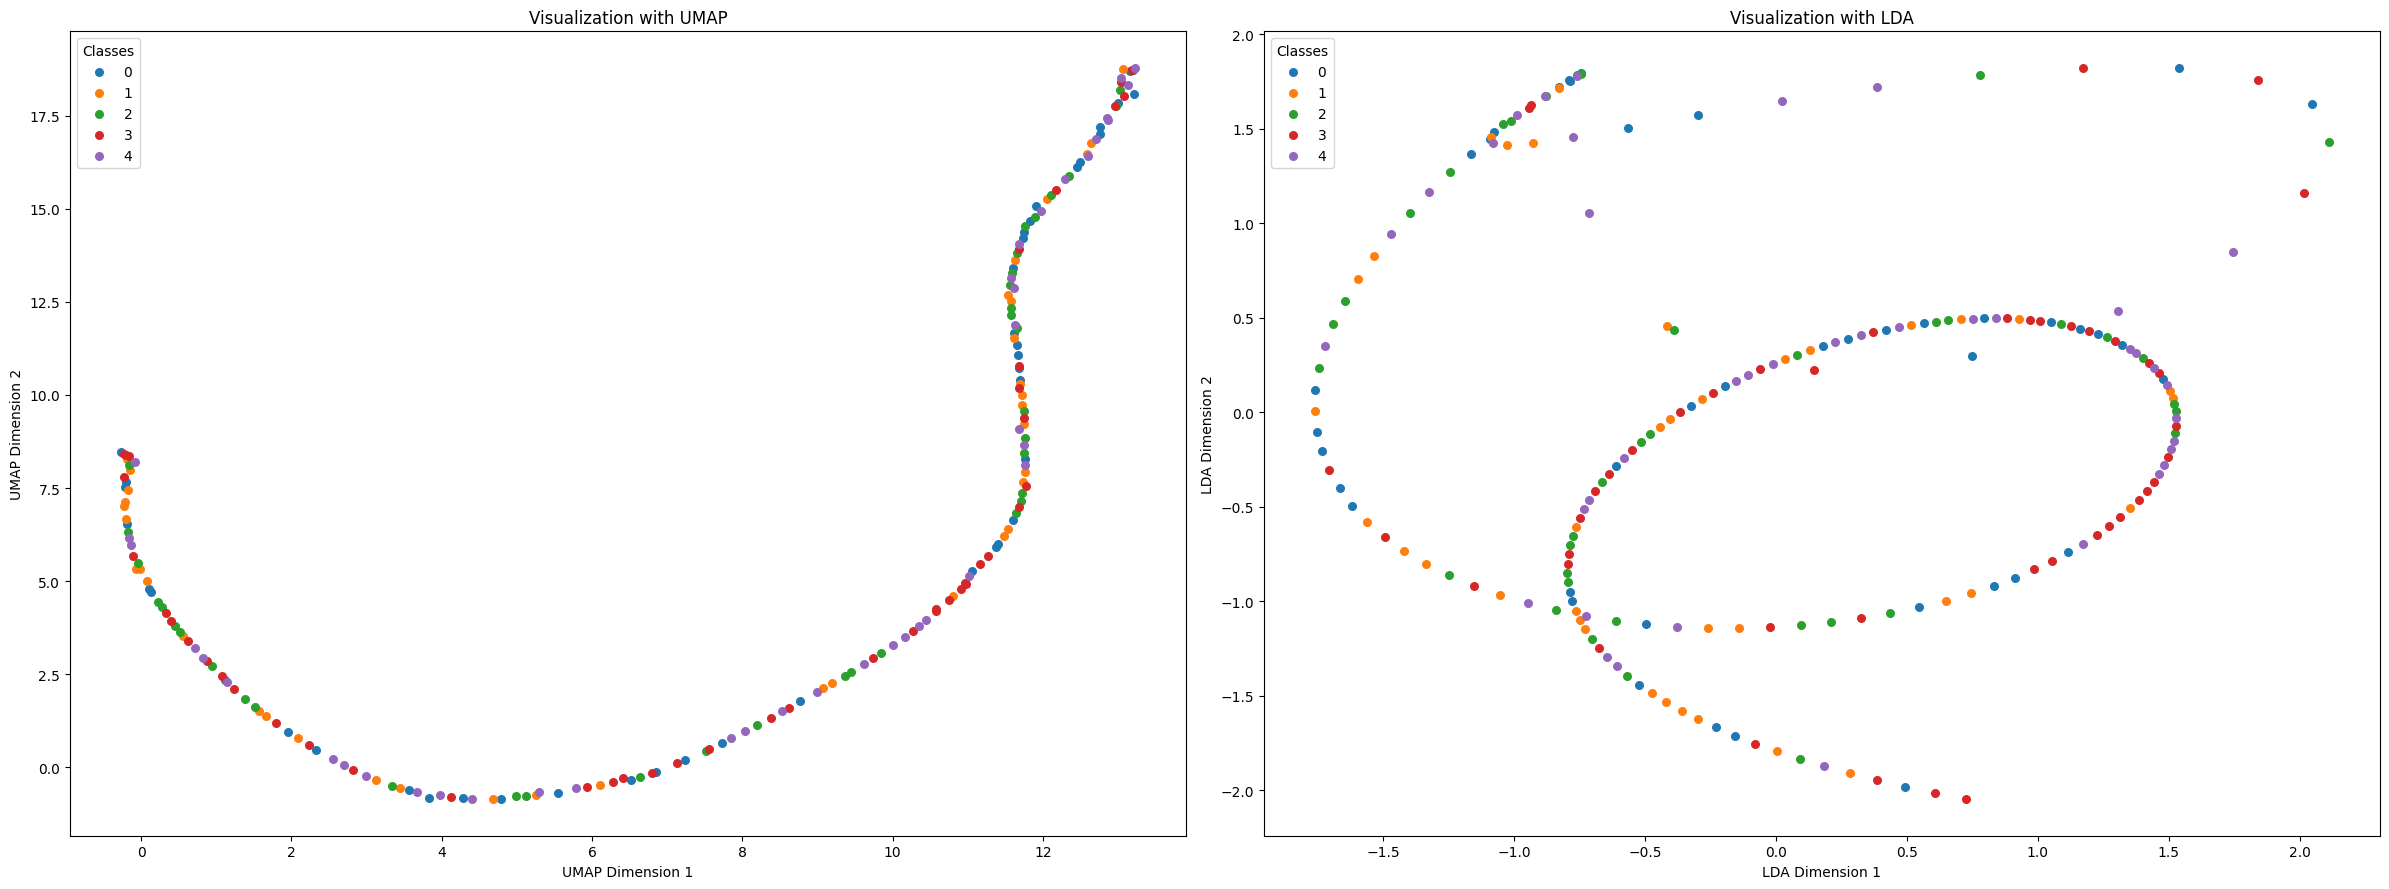

(200, 2)

In [10]:
#| test reduce_dimensions_latent_space
orbit_data = get_example_orbit_data()
orbit_data.shape

# Reshape data to 2D (num_orbits, 6 * num_time_points)
orbit_data_reshaped = orbit_data.reshape(200, -1)

# Use PCA to reduce to a lower-dimensional space (e.g., 10 dimensions)
pca = PCA(n_components=10)
latent_representations = pca.fit_transform(orbit_data_reshaped)

labels = np.random.randint(0, 5, size=200)  # 5 different classes

reduced_latent_spaces = reduce_dimensions_latent_space(latent_representations, labels, techniques=['UMAP','LDA'])
reduced_latent_spaces['UMAP'].shape

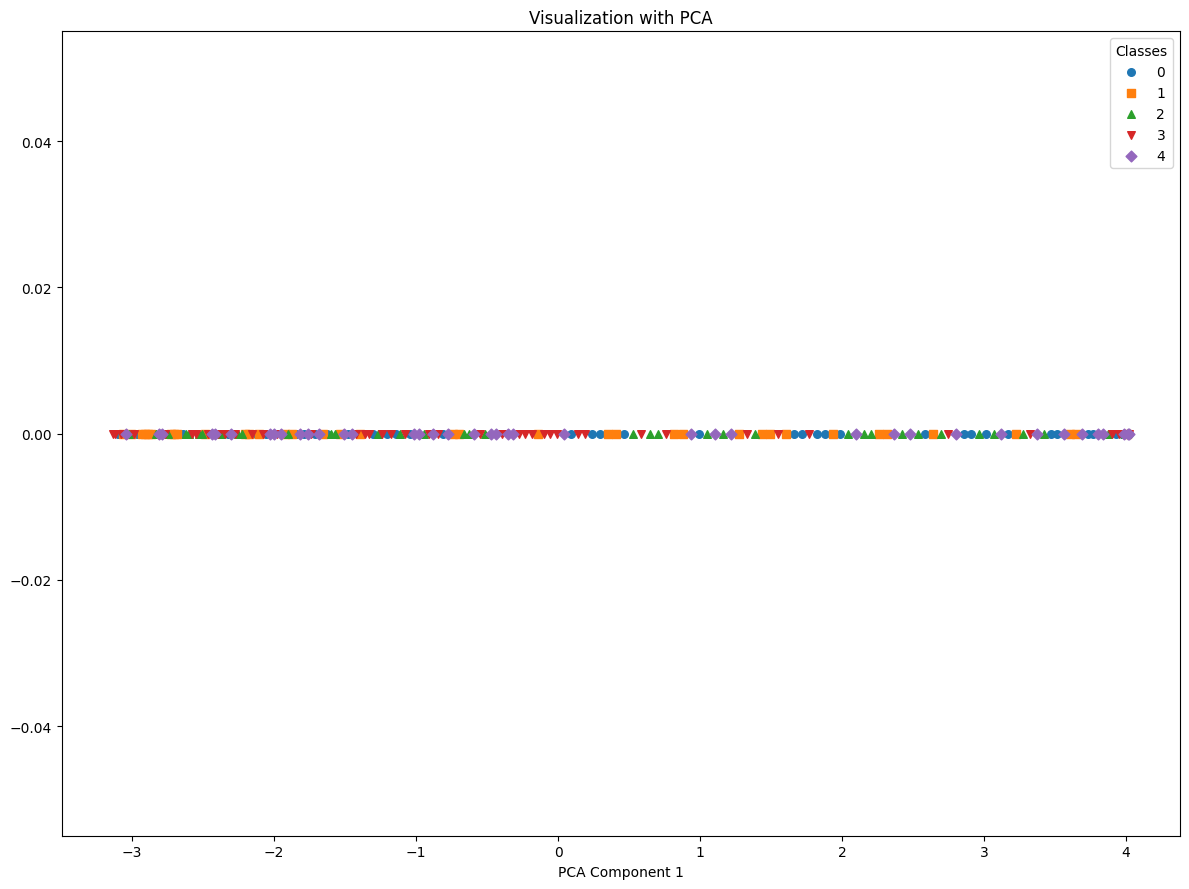

(200, 1)

In [11]:
#| test reduce_dimensions_latent_space
reduced_latent_spaces=reduce_dimensions_latent_space(latent_representations, labels, techniques=['PCA'], n_components=1, many_classes=True)
reduced_latent_spaces['PCA'].shape

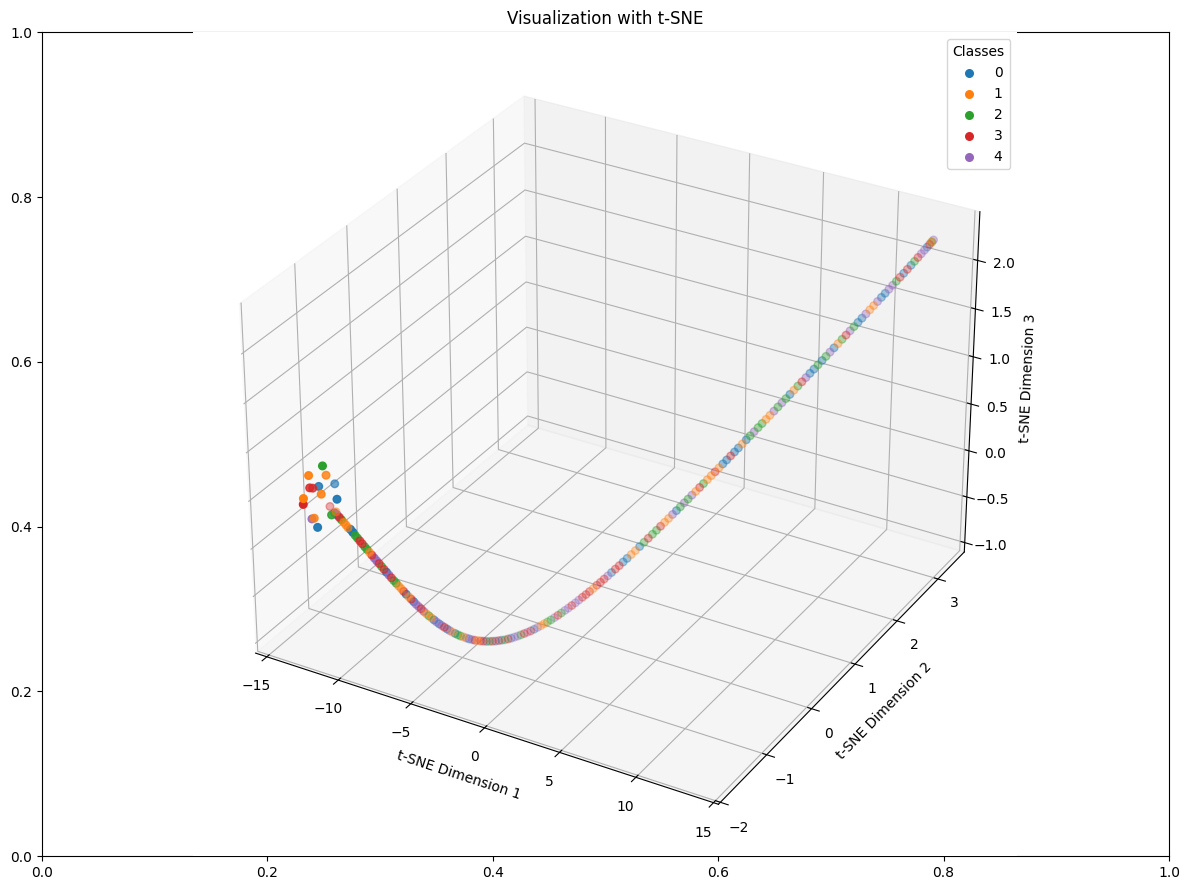

(200, 3)

In [12]:
#| test reduce_dimensions_latent_space
reduced_latent_spaces=reduce_dimensions_latent_space(latent_representations, labels, techniques=['t-SNE'], n_components=3)
reduced_latent_spaces['t-SNE'].shape

## Sampling

In [13]:
#| export
def sample_random_distributions(means, log_vars, n_samples: int, log_var_multiplier: float = 1.0) -> torch.Tensor:
    # Convert to PyTorch tensors if inputs are NumPy arrays
    if isinstance(means, np.ndarray):
        means = torch.from_numpy(means).float()
    if isinstance(log_vars, np.ndarray):
        log_vars = torch.from_numpy(log_vars).float()

    assert means.shape == log_vars.shape, "Means and log variances must have the same shape"
    assert means.dim() == 2, "Input tensors must be 2-dimensional"

    num_distributions, latent_dim = means.shape
    sampling_layer = Sampling()
    samples = []

    # Apply log variance multiplier
    log_vars = log_vars * log_var_multiplier

    distribution_idx = 0

    for _ in range(n_samples):
        # Select distribution iteratively
        idx = distribution_idx % num_distributions
        distribution_idx += 1

        # Get the mean and log variance for the chosen distribution
        z_mean = means[idx].unsqueeze(0)
        z_log_var = log_vars[idx].unsqueeze(0)

        # Sample from the chosen distribution
        sample = sampling_layer.forward(z_mean, z_log_var)
        samples.append(sample)

    # Stack all samples into a single tensor
    return torch.cat(samples, dim=0)


In [14]:
#| export
def linear_interpolation(z1, z2, steps):
    """Perform linear interpolation between two points."""
    return np.linspace(z1, z2, steps)

def slerp(z1, z2, steps):
    """Perform spherical linear interpolation between two points."""
    z1_norm = z1 / np.linalg.norm(z1)
    z2_norm = z2 / np.linalg.norm(z2)
    dot_product = np.clip(np.dot(z1_norm, z2_norm), -1.0, 1.0)
    omega = np.arccos(dot_product)
    if omega == 0:
        return np.tile(z1, (steps, 1))
    sin_omega = np.sin(omega)
    return np.array([
        (np.sin((1 - t) * omega) / sin_omega) * z1 +
        (np.sin(t * omega) / sin_omega) * z2
        for t in np.linspace(0, 1, steps)
    ])

def interpolate_sample(centroids, granularity=10, variance=0.0):
    """
    Perform interpolating sampling between all pairs of centroids.

    Parameters:
    - centroids (np.ndarray): Array of shape (n_centroids, latent_dim).
    - granularity (int): Number of interpolation steps between each pair.
    - variance (float): Standard deviation for Gaussian sampling.

    Returns:
    - samples (np.ndarray): Array of sampled points.
    """
    latent_dim = centroids.shape[1]
    samples = []

    for z1, z2 in combinations(centroids, 2):
        if latent_dim <= 2:
            interpolated = linear_interpolation(z1, z2, granularity)
        else:
            interpolated = slerp(z1, z2, granularity)
        
        if variance > 0:
            noise = np.random.normal(0, variance, interpolated.shape)
            interpolated += noise
        
        samples.append(interpolated)
    
    if samples:
        return np.vstack(samples)
    else:
        return np.empty((0, latent_dim))

In [15]:
# Define example centroids for a 2-dimensional latent space
centroids = np.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])

granularity = 3
variance = 0.0  # Set to 0 for deterministic interpolation

sampled_points = interpolate_sample(centroids, granularity, variance)

# Define the expected sampled points manually for granularity=3
expected_data = np.array([
    [1.0, 2.0],
    [2.0, 3.0],
    [3.0, 4.0],
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0],
    [3.0, 4.0],
    [4.0, 5.0],
    [5.0, 6.0]
])

# Check the sampled points against the expected data
test_eq(sampled_points, expected_data)

## Explore

In [16]:
#| export
def compute_centroids(latents, labels, method='mean', return_labels=False, **kwargs):
    """
    Compute the centroid of each class in the latent space using various methods.
    
    Parameters:
    - latents (np.ndarray): Array of shape (n_samples, latent_dim).
    - labels (np.ndarray): Array of shape (n_samples,) with class labels.
    - method (str): Method to compute centroids. Options: 'mean', 'median', 'geom_median', 'medoid', 'trimmed_mean', 'gmm'.
    - return_labels (bool): If True, also return the unique labels corresponding to the centroids.
    - kwargs: Additional arguments for specific methods.
    
    Returns:
    - centroids (np.ndarray): Array of shape (n_classes, latent_dim) containing centroids.
    - unique_labels (np.ndarray, optional): Array of shape (n_classes,) with unique class labels.
    """
    unique_labels = np.unique(labels)
    centroids = []
    
    for label in unique_labels:
        class_points = latents[labels == label]
        
        if method == 'mean':
            centroid = class_points.mean(axis=0)
        
        elif method == 'median':
            centroid = np.median(class_points, axis=0)
        
        elif method == 'geom_median':
            centroid = geometric_median(class_points, tol=kwargs.get('tol', 1e-5))
        
        elif method == 'medoid':
            centroid = compute_medoid(class_points)
        
        elif method == 'trimmed_mean':
            trim_ratio = kwargs.get('trim_ratio', 0.1)
            centroid = trimmed_mean_centroid(class_points, trim_ratio=trim_ratio)
        
        elif method == 'gmm':
            n_components = kwargs.get('n_components', 1)
            if n_components != 1:
                raise ValueError("GMM-based centroids require n_components=1 for simple centroid computation.")
            gmm = GaussianMixture(n_components=1)
            gmm.fit(class_points)
            centroid = gmm.means_[0]
        
        else:
            raise ValueError(f"Unsupported centroid computation method: {method}")
        
        centroids.append(centroid)
    
    centroids = np.array(centroids)
    
    if return_labels:
        return centroids, unique_labels
    else:
        return centroids

# Auxiliary Functions
def geometric_median(points, tol=1e-5):
    y = np.mean(points, axis=0)
    while True:
        D = distance.cdist([y], points, 'euclidean')[0]
        nonzeros = (D != 0)
        
        if not np.any(nonzeros):
            return y
        
        D = D[nonzeros]
        points_nonzero = points[nonzeros]
        y1 = np.sum(points_nonzero / D[:, np.newaxis], axis=0) / np.sum(1 / D)
        
        if np.linalg.norm(y - y1) < tol:
            return y1
        y = y1

def compute_medoid(points):
    dist_matrix = distance.cdist(points, points, 'euclidean')
    medoid_index = np.argmin(dist_matrix.sum(axis=1))
    return points[medoid_index]

def trimmed_mean_centroid(points, trim_ratio=0.1):
    trimmed_points = []
    for dim in range(points.shape[1]):
        sorted_dim = np.sort(points[:, dim])
        trim = int(trim_ratio * len(sorted_dim))
        trimmed_dim = sorted_dim[trim: -trim]
        trimmed_points.append(trimmed_dim)
    return np.array([np.mean(dim) for dim in trimmed_points])

In [17]:
#| hide

# Define example latent representations
latents = np.array([
    [1.0, 2.0],
    [1.5, -1.0],
    [2.0, -1.0],
    [1.2, 2.2],
    [1.4, 1.8],
    [1.7, 7.0]
])

# Define corresponding labels
labels = np.array([1,1,1,2,2,3])

# Compute centroids without returning labels
centroids = compute_centroids(latents, labels)

# Define the expected centroids
expected_centroids = np.array([
    [1.5, 0.],        # Centroid for label 1
    [1.3, 2.],        # Centroid for label 2
    [1.7, 7.]         # Centroid for label 2
])

# Check the computed centroids against the expected data
test_close(centroids, expected_centroids)

In [18]:
#| hide
import nbdev; nbdev.nbdev_export()